In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline 

import xgboost as xgb
from sklearn import cross_validation as cv
from sklearn import cross_validation as cv
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.calibration import CalibratedClassifierCV

warnings.filterwarnings("ignore")

In [4]:
train_raw = pd.read_csv("C:\\Users\\Sindhu\\Desktop\\Analytics\\Kaggle\\Datasets\\Black Friday\\train.csv")
test_raw = pd.read_csv("C:\\Users\\Sindhu\\Desktop\\Analytics\\Kaggle\\Datasets\\Black Friday\\test.csv")

combined = pd.concat([train_raw, test_raw], ignore_index= True)


In [5]:
# Gender 

combined.Gender[combined.Gender=='F'] = 0
combined.Gender[combined.Gender=='M'] = 1

# Age

combined.Age[combined.Age == '0-17'] = 0
combined.Age[combined.Age == '55+'] = 6
combined.Age[combined.Age == '26-35'] = 2
combined.Age[combined.Age == '46-50'] = 4
combined.Age[combined.Age == '51-55'] = 5
combined.Age[combined.Age == '36-45'] = 3
combined.Age[combined.Age == '18-25'] = 1

# City_Category
combined.City_Category[combined.City_Category == 'A'] = 0
combined.City_Category[combined.City_Category == 'B'] =1
combined.City_Category[combined.City_Category == 'C'] =2

# Stay_In_Current_City_Years
combined.Stay_In_Current_City_Years[combined.Stay_In_Current_City_Years== '2'] = 2
combined.Stay_In_Current_City_Years[combined.Stay_In_Current_City_Years== '4+'] = 4
combined.Stay_In_Current_City_Years[combined.Stay_In_Current_City_Years== '3'] = 3
combined.Stay_In_Current_City_Years[combined.Stay_In_Current_City_Years== '1'] = 1
combined.Stay_In_Current_City_Years[combined.Stay_In_Current_City_Years== '0'] = 0 




In [107]:
combined.Gender = combined.Gender.astype(int)
combined.Age = combined.Age.astype(int)
combined.City_Category = combined.City_Category.astype(int)
combined.Stay_In_Current_City_Years = combined.Stay_In_Current_City_Years.astype(int)
combined.User_ID = combined.User_ID.astype(int)

# Changing Product_ID labels for ease 
le =preprocessing.LabelEncoder()
le = le.fit(combined.Product_ID)
le_new= le.transform(combined.Product_ID)
combined.Product_ID = le_new




In [108]:
# Extra Features :

Product_mean = combined.groupby(combined.Product_ID).mean()['Purchase']
combined['Product_mean'] =combined.Product_ID.map(Product_mean)

combined['Diff'] = combined.Purchase - combined.Product_mean
Diff_mean = combined.groupby(combined.User_ID).mean()['Diff']
combined['Diff_mean'] =combined.User_ID.map(Diff_mean)

mean = combined.groupby(combined.Age).mean()['Purchase']
mean_map = combined.Age.map(mean)
combined['diff'] = combined.Purchase - mean_map
diff_mean = combined.groupby(combined.User_ID).mean()['diff']
combined['Age_Diff_mean'] =combined.User_ID.map(diff_mean)

mean = combined.groupby(combined.Gender).mean()['Purchase']
mean_map = combined.Gender.map(mean)
combined['diff'] = combined.Purchase - mean_map
diff_mean = combined.groupby(combined.User_ID).mean()['diff']
combined['Gender_Diff_mean'] =combined.User_ID.map(diff_mean)

mean = combined.groupby(combined.City_Category).mean()['Purchase']
mean_map = combined.City_Category.map(mean)
combined['diff'] = combined.Purchase - mean_map
diff_mean = combined.groupby(combined.User_ID).mean()['diff']
combined['City_Diff_mean'] =combined.User_ID.map(diff_mean)

mean = combined.groupby(combined.Product_Category_1).mean()['Purchase']
mean_map = combined.Product_Category_1 .map(mean)
combined['diff'] = combined.Purchase - mean_map
diff_mean = combined.groupby(combined.User_ID).mean()['diff']
combined['PC1_Diff_mean'] =combined.User_ID.map(diff_mean)


mean = combined.groupby(combined.Occupation).mean()['Purchase']
mean_map = combined.Occupation.map(mean)
combined['diff'] = combined.Purchase - mean_map
diff_mean = combined.groupby(combined.User_ID).mean()['diff']
combined['Occupation_Diff_mean'] =combined.User_ID.map(diff_mean)


# User into bins 
bins= pd.qcut(combined.groupby('User_ID')['Purchase'].sum(), 10,labels= [0,1,2,3,4,5,6,7,8,9])
combined['User_Cat']=combined['User_ID'].map(bins)

mean = combined.groupby(combined.User_Cat).mean()['Purchase']
mean_map = combined.User_Cat.map(mean)
combined['diff'] = combined.Purchase - mean_map
diff_mean = combined.groupby(combined.User_ID).mean()['diff']
combined['User_Cat_Diff_mean'] =combined.User_ID.map(diff_mean)




In [109]:
combined= combined.drop(['User_ID','Diff','Product_ID','diff','User_Cat','Product_Category_3'], axis=1)



combined['0-1'] = combined['Diff']

n = combined.shape[0]

for i in range(n) :
    if combined.iloc[i]['Diff'] > 0 :
        combined.iloc[i]['0-1'] = 1
    else :
        combined.iloc[i]['0-1'] = 0
    
        

In [112]:

train = combined.iloc[0:550068]
test = combined.iloc[550068:783667]
test =test.drop(['Purchase'], axis=1)
test =test.reset_index(drop=True)

In [113]:
# Train test split

train_data, test_data = cv.train_test_split(train, test_size=0.25)

# For sample
x_train_a = train_data.drop(['Purchase'], axis =1).values
y_train_a = train_data['Purchase'].ravel()
x_test_a = test_data.drop(['Purchase'], axis=1).values
y_test_a =test_data['Purchase'].ravel()


# For final 
x_train_f = train.drop(['Purchase'], axis =1).values
x_test_f = test.values
y_train_f = train['Purchase'].ravel()



In [119]:
# For GBM

params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.03
params["min_child_weight"] = 10
params["subsample"] = 0.8
params["colsample_bytree"] = 0.7
params["silent"] = 1
params["max_depth"] = 10
#params["max_delta_step"]=2
params["seed"] = 0
#params['eval_metric'] = "auc"
plst = list(params.items())
num_rounds = 1000

  


In [58]:
# For sample error

xgtrain = xgb.DMatrix(x_train_a, label=y_train_a)
xgtest = xgb.DMatrix(x_test_a)
model = xgb.train(plst, xgtrain, num_rounds)
pred_test_y = model.predict(xgtest)

print 'Finished training the model'
    
rmse = sqrt(mean_squared_error(pred_test_y, y_test_a))
print rmse


Finished training the model
2411.94152095


In [120]:
# For actual error
xgtrain = xgb.DMatrix(x_train_f, label=y_train_f)
xgtest = xgb.DMatrix(x_test_f)
model = xgb.train(plst, xgtrain, num_rounds)
final_y = model.predict(xgtest)

print 'Finished training the model'

Finished training the model


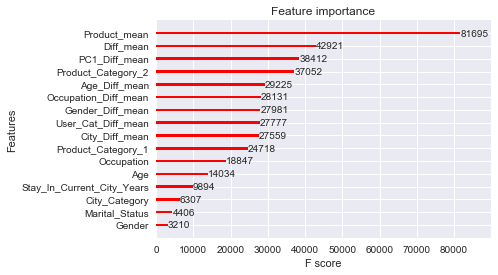

In [121]:
xgtrain.feature_names = ['Age', 'City_Category','Gender','Marital_Status','Occupation','Product_Category_1','Product_Category_2',
                           'Stay_In_Current_City_Years','Product_mean','Diff_mean','Age_Diff_mean', 'Gender_Diff_mean',
                         'City_Diff_mean','PC1_Diff_mean','Occupation_Diff_mean','User_Cat_Diff_mean']

model.get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(xgtrain.feature_names)}
mapped = {mapper[k]: v for k, v in model.get_fscore().items()}
mapped
xgb.plot_importance(mapped, color='red')

In [122]:
# For creating the output file

output =pd.DataFrame(columns=['User_ID','Product_ID', 'Purchase'])
output['User_ID'] = test_raw['User_ID']
output['Product_ID'] = test_raw['Product_ID']
output['Purchase'] = final_y

output.to_csv("output.csv", index=False)

print 'Finished creating the output file'


Finished creating the output file
